# Проект: Обучение с учителем: качество модели

## Описание проекта

### Основная суть

    Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

    «В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 


### Цель исследования

* Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

### Задачи исследования

1. Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.

2. Выделить сегменты покупателей и разработать для них персонализированные предложения.

### Исходные данные

* market_file.csv - данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
* market_money.csv - данные о выручке, которую получает магазин с покупателя.
* market_time.csv - данные о времени, которое покупатель провёл на сайте в течение периода.
* money.csv - данные о среднемесячной прибыли покупателя за последние 3 месяца

### План проекта

1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение таблиц
5. Корреляционный анализ
6. Использование пайплайнов
7. Анализ важности признаков
8. Сегментация покупателей
9. Общий вывод

## Подключение библиотек

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

import shap

## Загрузка данных

In [58]:
market_file = pd.read_csv('datasets/market_file.csv')
market_money = pd.read_csv('datasets/market_money.csv')
market_time = pd.read_csv('datasets/market_time.csv')
money = pd.read_csv('datasets/money.csv', delimiter=';', decimal = ',')

In [59]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


В этой таблице находится покупательская активность клиента, время с момента регистрации на сайте, значение маркетинговой коммуникации с заказчиком, самая популярная категория товаров у покупателя, доля покупок по акции и тд

In [60]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Таблица с суммой выручки от покупателя за определенный период

In [61]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Время (в минутах), которое покупатель провёл на сайте в течение определенного периода

In [62]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Среднемесячная прибыль от покупателя за последние 3 месяца

## Предобработка данных

### Дубликаты и пропуски

Функция для проверки датасета на дубликаты и пропуски

In [63]:
def passes_duplicated(df):
    print("Пропуски:")
    print(df.isnull().sum())
    print("-----------------------------------------")
    print(f'Кол-во дубликатов: {df.duplicated().sum()}')

In [64]:
passes_duplicated(market_file)

Пропуски:
id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64
-----------------------------------------
Кол-во дубликатов: 0


In [65]:
passes_duplicated(market_money)

Пропуски:
id         0
Период     0
Выручка    0
dtype: int64
-----------------------------------------
Кол-во дубликатов: 0


In [66]:
passes_duplicated(market_time)

Пропуски:
id        0
Период    0
минут     0
dtype: int64
-----------------------------------------
Кол-во дубликатов: 0


In [67]:
passes_duplicated(money)

Пропуски:
id         0
Прибыль    0
dtype: int64
-----------------------------------------
Кол-во дубликатов: 0


### Типы данных

В датафреймах нет пропусков и явных дубликатов, проверим типы данных в столбцах

In [68]:
def data_types(df):
    print(df.dtypes)

In [69]:
data_types(market_file)
market_file.head()

id                                       int64
Покупательская активность               object
Тип сервиса                             object
Разрешить сообщать                      object
Маркет_актив_6_мес                     float64
Маркет_актив_тек_мес                     int64
Длительность                             int64
Акционные_покупки                      float64
Популярная_категория                    object
Средний_просмотр_категорий_за_визит      int64
Неоплаченные_продукты_штук_квартал       int64
Ошибка_сервиса                           int64
Страниц_за_визит                         int64
dtype: object


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [70]:
data_types(market_money)
market_money.head()

id           int64
Период      object
Выручка    float64
dtype: object


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [71]:
data_types(market_time)
market_time.head()

id         int64
Период    object
минут      int64
dtype: object


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [72]:
data_types(money)
money.head()

id           int64
Прибыль    float64
dtype: object


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Переведем прибыль в тип float и снова применим функцию

In [73]:
data_types(money)
money.head()

id           int64
Прибыль    float64
dtype: object


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### Неявные дубликаты

Проверим данные на неявные дубликаты

In [74]:
def implicit_duplicates(df, columns):
    for col in columns:
        print(f'{col}: {" | ".join(map(str, df[col].unique()))}')

In [75]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [76]:
col_list = ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']
implicit_duplicates(market_file, col_list)

Покупательская активность: Снизилась | Прежний уровень
Тип сервиса: премиум | стандартт | стандарт
Разрешить сообщать: да | нет
Популярная_категория: Товары для детей | Домашний текстиль | Косметика и аксесуары | Техника для красоты и здоровья | Кухонная посуда | Мелкая бытовая техника и электроника


Заменим неявные дубликаты в Тип сервиса

In [77]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].str.replace('стандартт', 'стандарт')

In [78]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [79]:
col_list = ['Период']
implicit_duplicates(market_money, col_list)

Период: препредыдущий_месяц | текущий_месяц | предыдущий_месяц


In [80]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [81]:
col_list = ['Период']
implicit_duplicates(market_time, col_list)

Период: текущий_месяц | предыдцщий_месяц


In [82]:
market_time['Период'] = market_time['Период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')

In [83]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### Вывод


Проверили датафреймы на пропуски и дубликаты. Посмотрели типы данных - в money['Прибыль'], исправили на float. Проверили на неявные дубликаты и исправили ошибки.

## Исследовательский анализ данных

### Статистический анализ

В этом пункте проведем статистический анализ всех признаков, построим графики, посмотрим получше на распределения данных и выбросы

In [84]:
def build_hist(df):
    columns = df.drop('id', axis=1).select_dtypes(include='number').columns
    for col in columns:
        bins = round(df[col].size ** 0.5)
        plt.title(col)
        df[col].hist(bins=bins, color='#50af31')
        plt.grid(True)
        plt.show()

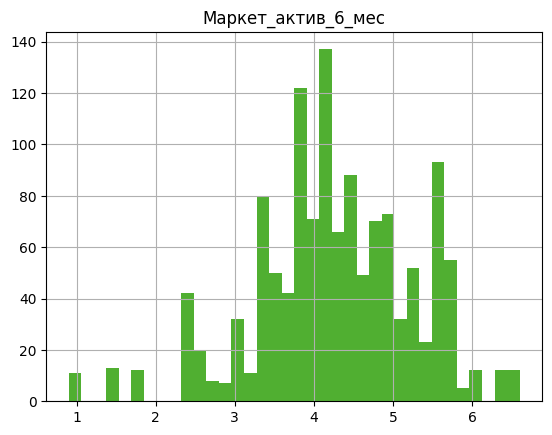

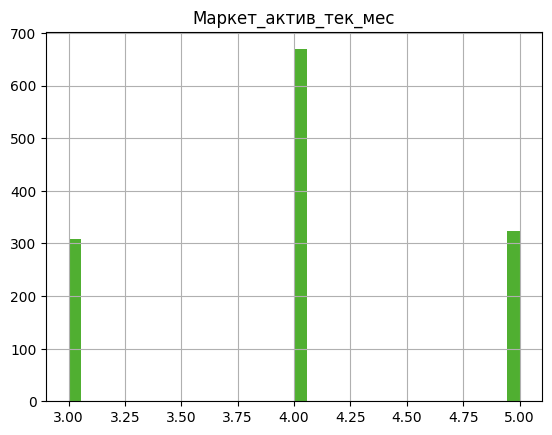

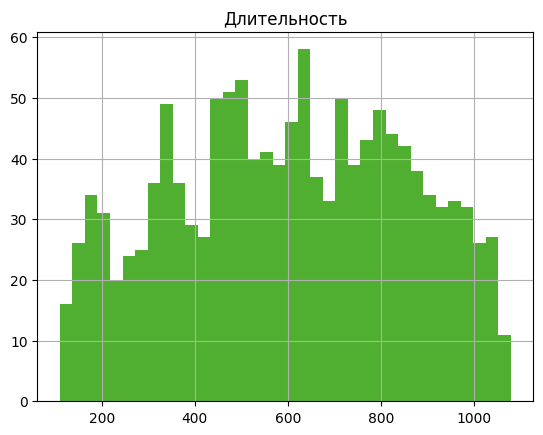

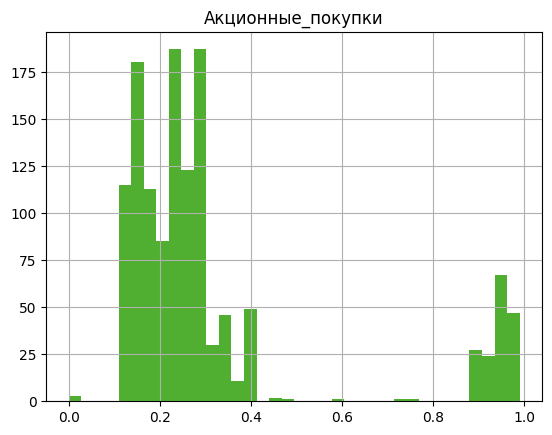

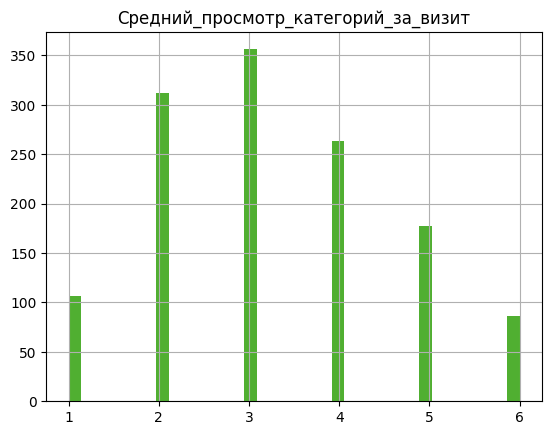

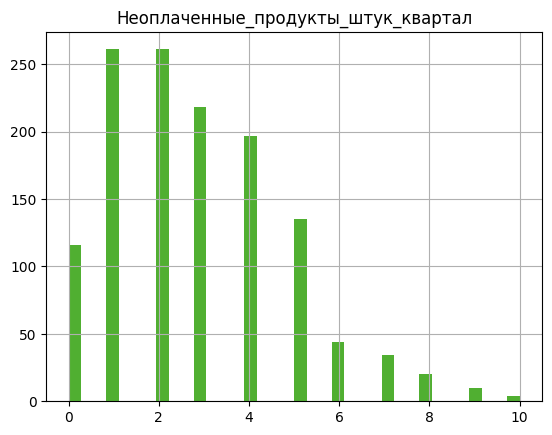

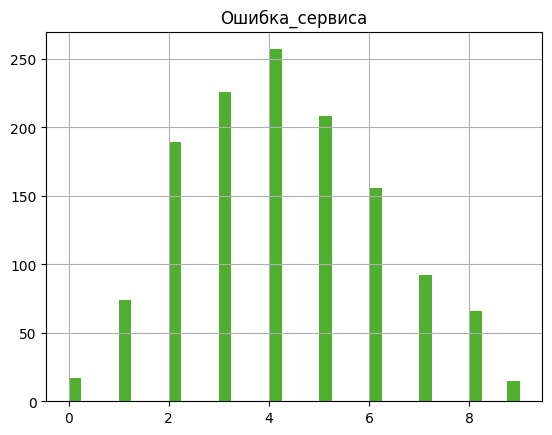

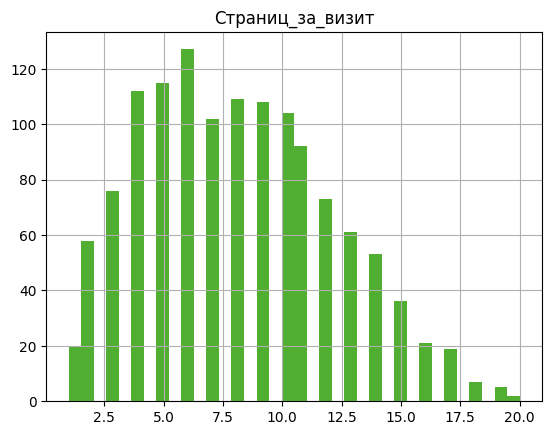

In [85]:
build_hist(market_file)

Из графиков видим, что средний маркетинговый актив компании с покупателями за последние 6 месяцев составляет в основном от 3 до 5 сообщений, как и за последний месяц. Количество дней на сайте составляет от 200 до 1000, можем сделать вывод, что новых пользователей становится меньше. У большого количества покупателей доля купленных товаров по акции - 0.1 - 0.4, много и таких которые покупают товары только по акции. Обычно пользователи простматривают 2 - 4 категории товаров за визит. Достаточно пользователей, которые оплачивают все товары, добавленные в корзину. Число сбоев во время посещения сайта покупателем имеет нормальное распределение и составляет обычно 3 - 5 раз. За последние 3 месяца пользователь просматрел, как правило, 5 - 10 страниц. 

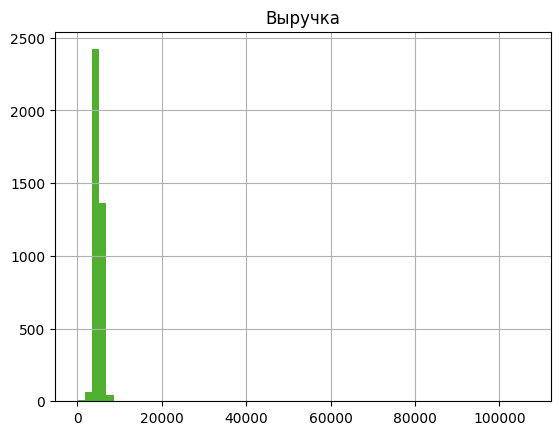

In [86]:
build_hist(market_money)

In [87]:
market_money['Выручка'].max(), market_money['Выручка'].min(), market_money['Выручка'].median(), 

(106862.2, 0.0, 4957.5)

Удалим выбросы в сумме выручки от покупателя

In [88]:
market_money = market_money[market_money['Выручка'] < 15000]

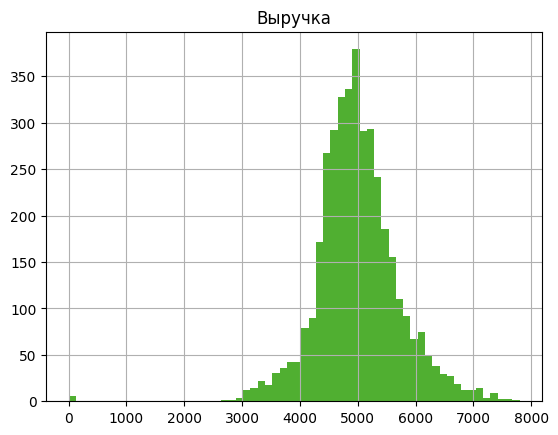

In [89]:
build_hist(market_money)

Сумма выручки имеет нормальное распределение и составляет, как правило, от 4к до 6к

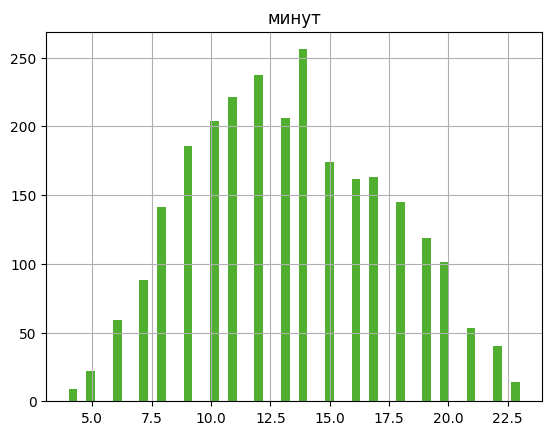

In [90]:
build_hist(market_time)

Время покупателя на сайте имеет нормальное распределение и составляет обычно от 10 до 14 минут

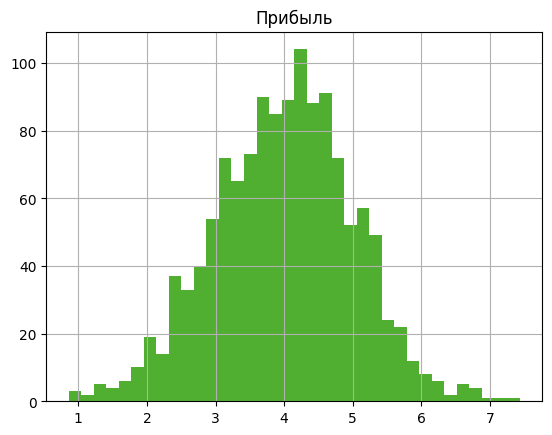

In [91]:
build_hist(money)

Cреднемесячная прибыль от покупателя за последние 3 месяца тоже имеет нормальное распределение и составляет от 3 до 5 тысяч

Посмотрим на распределение категориальных данных

In [92]:
def categorical_data(df):
    columns = df.select_dtypes(exclude='number').columns
    for col in columns:
        df_table = df[col].value_counts()
        df_table.index = df[col].unique()
        pallete = ['#6694c5', '#50af31', '#004f9e', '#96ce83', '#c9c5c5', '#224c75']
        colors = pallete[:len(df_table)]
        df_table.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), colors=colors)
        plt.title(col, loc='center') 
        plt.ylabel('')
        plt.show()

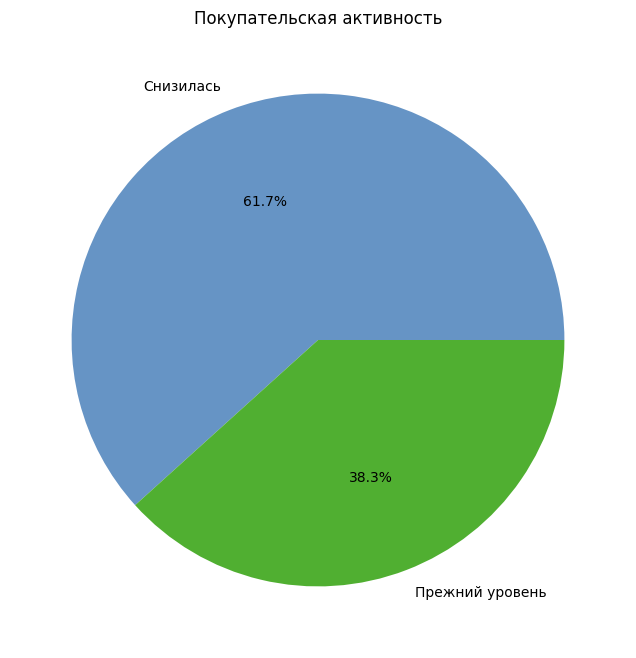

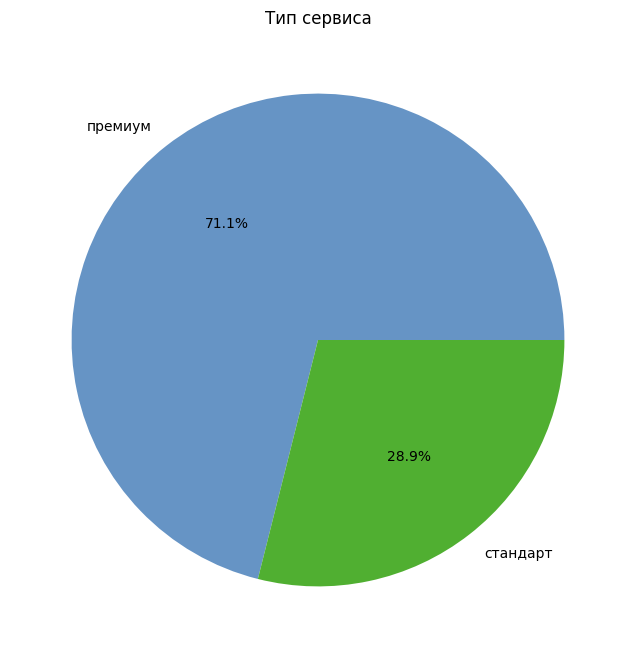

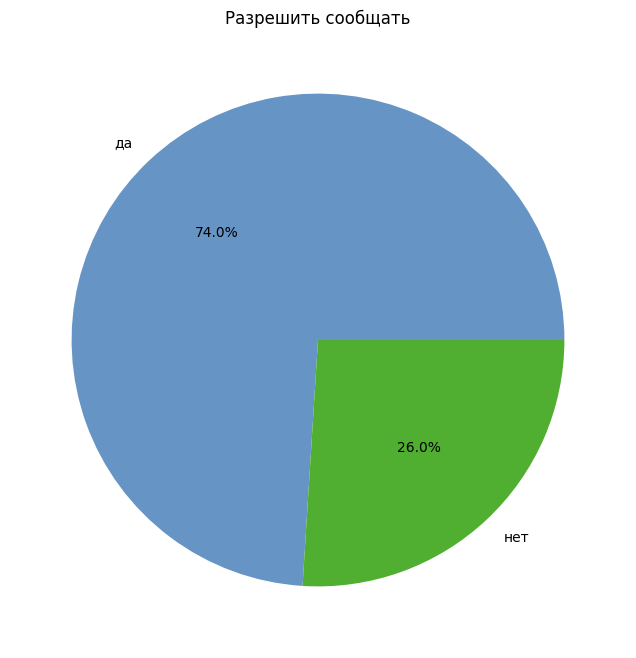

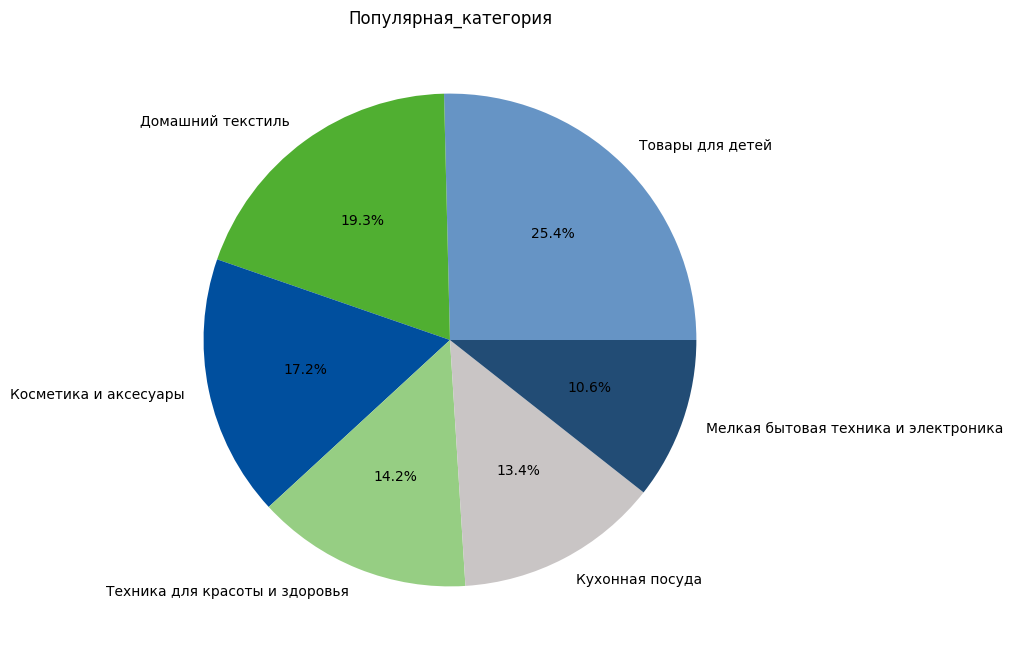

In [93]:
categorical_data(market_file)

Покупатели со сниженной активностью составляет 2/3 датасета. У 71% из покупателей премиум сервис. 3/4 покупателей разрешают присылать доп. информацию о товаре. Распределение по любимым категориям примерно равномерное, наиболее частая - товары для детей

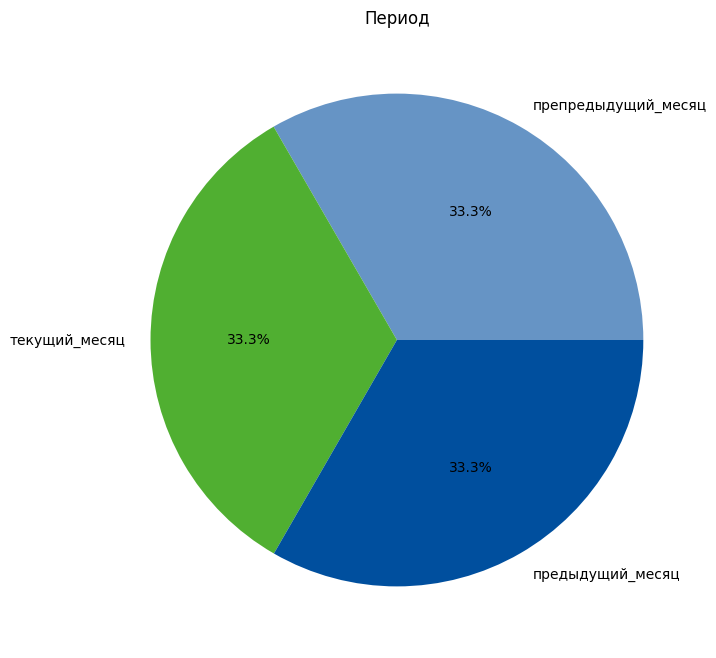

In [94]:
categorical_data(market_money)

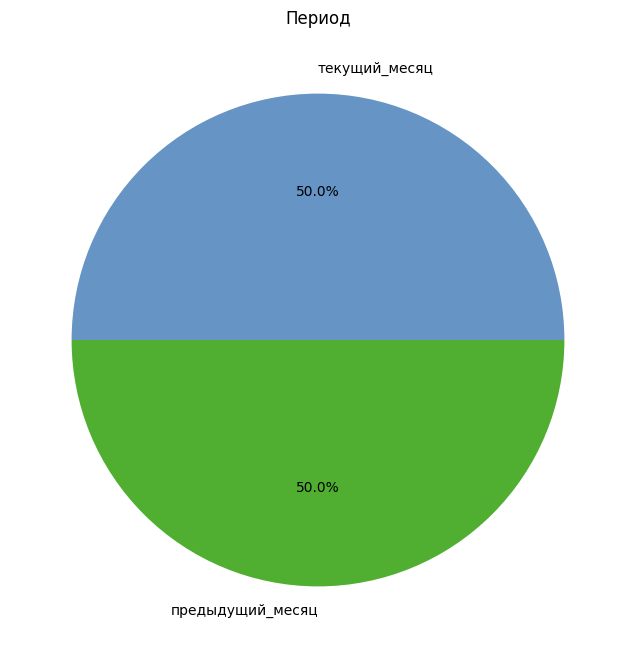

In [95]:
categorical_data(market_time)

### Отбор клиентов с покупательской активностью

Уберем клиентов, которые ничего не покупали за последние 3 месяца

In [96]:
market_money = market_money[market_money['Выручка'] != 0]

### Вывод

В этом пункте посмотрели статистики по количественным и категориальным данным в таблицах; отобрали клиентов с покупательской активностью за последние 3 месяца

## Объединение таблиц

### Объединение market_file.csv, market_money.csv, market_time.csv. 

In [97]:
market = market_file

In [98]:
current_month = market_money[market_money['Период'] == 'текущий_месяц'][['id', 'Выручка']]
current_month.columns = ['id', 'Выручка_текущий']
market = pd.merge(market, current_month, on='id')

In [99]:
previous_month = market_money[market_money['Период'] == 'предыдущий_месяц'][['id', 'Выручка']]
previous_month.columns = ['id', 'Выручка_предыдущий']
market = pd.merge(market, previous_month, on='id')

In [100]:
preprevious_month = market_money[market_money['Период'] == 'препредыдущий_месяц'][['id', 'Выручка']]
preprevious_month.columns = ['id', 'Выручка_препредыдущий']
market = pd.merge(market, preprevious_month, on='id')

In [101]:
current_time = market_time[market_time['Период'] == 'текущий_месяц'][['id', 'минут']]
current_time.columns = ['id', 'Время_текущий_мин']
market = pd.merge(market, current_time, on='id')

In [102]:
previous_time = market_time[market_time['Период'] == 'предыдущий_месяц'][['id', 'минут']]
previous_time.columns = ['id', 'Время_предыдущий_мин']
market = pd.merge(market, previous_time, on='id')

In [103]:
market.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий,Выручка_предыдущий,Выручка_препредыдущий,Время_текущий_мин,Время_предыдущий_мин
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13,11
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10


Проверим итоговый датафрейм на пропуски и дубликаты

In [104]:
passes_duplicated(market)

Пропуски:
id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
Выручка_текущий                        0
Выручка_предыдущий                     0
Выручка_препредыдущий                  0
Время_текущий_мин                      0
Время_предыдущий_мин                   0
dtype: int64
-----------------------------------------
Кол-во дубликатов: 0


## Корреляционный анализ

### Основная часть

In [105]:
market.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий,Выручка_предыдущий,Выручка_препредыдущий,Время_текущий_мин,Время_предыдущий_мин
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13,11
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10


In [106]:
corr = market.drop('id', axis=1).select_dtypes(include=['number']).corr(method='spearman')
corr.style.background_gradient(cmap='terrain')

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий,Выручка_предыдущий,Выручка_препредыдущий,Время_текущий_мин,Время_предыдущий_мин
Маркет_актив_6_мес,1.000000,0.061741,-0.044445,-0.276590,0.185013,-0.135045,0.038643,0.319872,0.002093,-0.003642,0.234728,0.226968,0.273727
Маркет_актив_тек_мес,0.061741,1.000000,-0.131967,0.033099,-0.025167,0.061747,0.087343,0.003143,-0.011782,-0.027088,-0.039437,-0.063051,0.013535
Длительность,-0.044445,-0.131967,1.000000,0.029045,-0.043154,-0.108787,0.103562,-0.034495,0.015002,0.013537,-0.039301,0.083048,-0.123940
Акционные_покупки,-0.276590,0.033099,0.029045,1.000000,-0.203401,0.198307,-0.051593,-0.370860,0.022255,0.005184,-0.269087,-0.275313,-0.332548
Средний_просмотр_категорий_за_визит,0.185013,-0.025167,-0.043154,-0.203401,1.000000,-0.251559,0.010034,0.267479,-0.070716,-0.049460,0.149742,0.233369,0.148279
Неоплаченные_продукты_штук_квартал,-0.135045,0.061747,-0.108787,0.198307,-0.251559,1.000000,-0.098582,-0.165412,0.061178,0.033434,-0.249293,-0.214699,-0.183575
Ошибка_сервиса,0.038643,0.087343,0.103562,-0.051593,0.010034,-0.098582,1.000000,0.104482,0.040477,0.035476,0.090152,0.078074,0.196009
Страниц_за_визит,0.319872,0.003143,-0.034495,-0.370860,0.267479,-0.165412,0.104482,1.000000,-0.049964,-0.067610,0.311675,0.298120,0.450760
Выручка_текущий,0.002093,-0.011782,0.015002,0.022255,-0.070716,0.061178,0.040477,-0.049964,1.000000,0.879097,0.149944,-0.164851,-0.143371
Выручка_предыдущий,-0.003642,-0.027088,0.013537,0.005184,-0.049460,0.033434,0.035476,-0.067610,0.879097,1.000000,0.308041,-0.083214,-0.084215


### Вывод

Проверили признаки на мультиколлинеарность с помощью матрицы корреляции

##  Использование пайплайнов

### Подготовка данных

In [107]:
X = market.drop(['Покупательская активность', 'id'], axis=1)
y = market['Покупательская активность']
print(y.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, stratify=y)

Покупательская активность
Прежний уровень    802
Снизилась          494
Name: count, dtype: int64


In [108]:
X_train.shape, X_test.shape

((972, 16), (324, 16))

In [109]:
X.head()

,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий,Выручка_предыдущий,Выручка_препредыдущий,Время_текущий_мин,Время_предыдущий_мин
0,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12
1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8
2,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13,11
3,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8
4,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10


Разделим все колонки на количесвенные, категориальные и ранговые признаки

In [110]:
ohe_columns = ['Разрешить сообщать', 'Популярная_категория']
ord_columns = ['Тип сервиса']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 
               'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал',
               'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_текущий', 'Выручка_предыдущий',
               'Выручка_препредыдущий', 'Время_текущий_мин', 'Время_предыдущий_мин']

Пайплайн для подготовки данных

In [111]:
data_preprocessor = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first'), ohe_columns),
     ('ord', OrdinalEncoder(), ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Итоговый пайплайн

In [112]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=42))
])

In [113]:
param_grid = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeClassifier(random_state=42)],
        'models__max_depth': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    {
        'models': [SVC(random_state=42, probability=True)],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  

    },
    {
        'models': [LogisticRegression(random_state=42, solver='liblinear', penalty='l1', max_iter=1000)],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    }
] 

### Выбор метрики

Так как классы не сбалансированы (Прежний уровень - 2/3 выборки, Снизилась - 1/3) и задача представляет собой бинарную классификацию выберем метрику roc-auc. 

### Поиск лучшей модели

In [114]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_iter = 20,
    n_jobs=-1
)

Выведем параметры наилучшей модели

In [115]:
randomized_search.fit(X_train, y_train)
best_model = randomized_search.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('ord', OrdinalEncoder(),
                                                  ['Тип сервиса']),
                                                 ('num', StandardScaler(),
                                                  ['Маркет_актив_6_мес',
                                                   'Маркет_актив_тек_мес',
                                                   'Длительность',
                                                   'Акционные_покупки',
                                                   'Средний_просмотр_категорий_за_визит',
                                                   'Неоплаченные_продукты_штук_квартал',
                                                   'Ошибка_сервиса',
                                                   'Страниц_за_визит',
                                                   'Выручка_текущий',
                                                   'Выручка_предыдущий',
                                                   'Выручка_препредыдущий',
                                                   'Время_текущий_мин',
                                                   'Время_предыдущий_мин'])])),
                ('models', SVC(C=1, probability=True, random_state=42))])

In [116]:
y_proba = best_model.predict_proba(X_train)[:, 1]
roc_auc = roc_auc_score(y_train, y_proba)
roc_auc

0.968471236169726

Наилучшая модель - SVC(C=1), метрика на тестовых данных - 0.9

Выведем все модели, которые были рассмотрены. Видим, что SVC показывал себя наилучшим образом

In [117]:
result = pd.DataFrame(randomized_search.cv_results_)
result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
5,1,"SVC(probability=True, random_state=42)",0.908336,"{'preprocessor__num': StandardScaler(), 'model..."
15,2,"SVC(probability=True, random_state=42)",0.908033,"{'preprocessor__num': StandardScaler(), 'model..."
9,3,"SVC(probability=True, random_state=42)",0.901563,"{'preprocessor__num': MinMaxScaler(), 'models_..."
3,4,"LogisticRegression(max_iter=1000, penalty='l1'...",0.898360,"{'preprocessor__num': MinMaxScaler(), 'models_..."
10,5,"SVC(probability=True, random_state=42)",0.898047,"{'preprocessor__num': MinMaxScaler(), 'models_..."
16,6,"LogisticRegression(max_iter=1000, penalty='l1'...",0.896638,"{'preprocessor__num': MinMaxScaler(), 'models_..."
1,7,"LogisticRegression(max_iter=1000, penalty='l1'...",0.896414,"{'preprocessor__num': MinMaxScaler(), 'models_..."
6,8,"SVC(probability=True, random_state=42)",0.896207,"{'preprocessor__num': MinMaxScaler(), 'models_..."
18,9,"LogisticRegression(max_iter=1000, penalty='l1'...",0.896081,"{'preprocessor__num': StandardScaler(), 'model..."
7,10,"LogisticRegression(max_iter=1000, penalty='l1'...",0.896015,"{'preprocessor__num': StandardScaler(), 'model..."


### Предсказание на тестовых данных

In [118]:
y_proba = best_model.predict_proba(X_test)

In [119]:
roc_auc = roc_auc_score(y_test, y_proba[:, 1])
roc_auc

0.9124701694778142

Результат на тестовых данных - 0.91

## Анализ важности признаков

### График SHAP

С помощью графика важности SHAP проанализируем вклад каждого признака в предсказание модели

In [120]:
preprocessor = best_model.named_steps['preprocessor']
X_sample = X_train.sample(100, random_state=42)
X_sample_transformed = preprocessor.transform(X_sample)
X_sample.columns

Index(['Тип сервиса', 'Разрешить сообщать', 'Маркет_актив_6_мес',
       'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки',
       'Популярная_категория', 'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Выручка_текущий', 'Выручка_предыдущий',
       'Выручка_препредыдущий', 'Время_текущий_мин', 'Время_предыдущий_мин'],
      dtype='object')

In [121]:
columns = preprocessor.transformers_[0][1].get_feature_names_out().tolist()
columns.append(preprocessor.transformers_[1][1].get_feature_names_out().tolist()[0])
columns_num = preprocessor.transformers_[2][1].get_feature_names_out().tolist()
for col in columns_num:
    columns.append(col)

  0%|          | 0/100 [00:00<?, ?it/s]

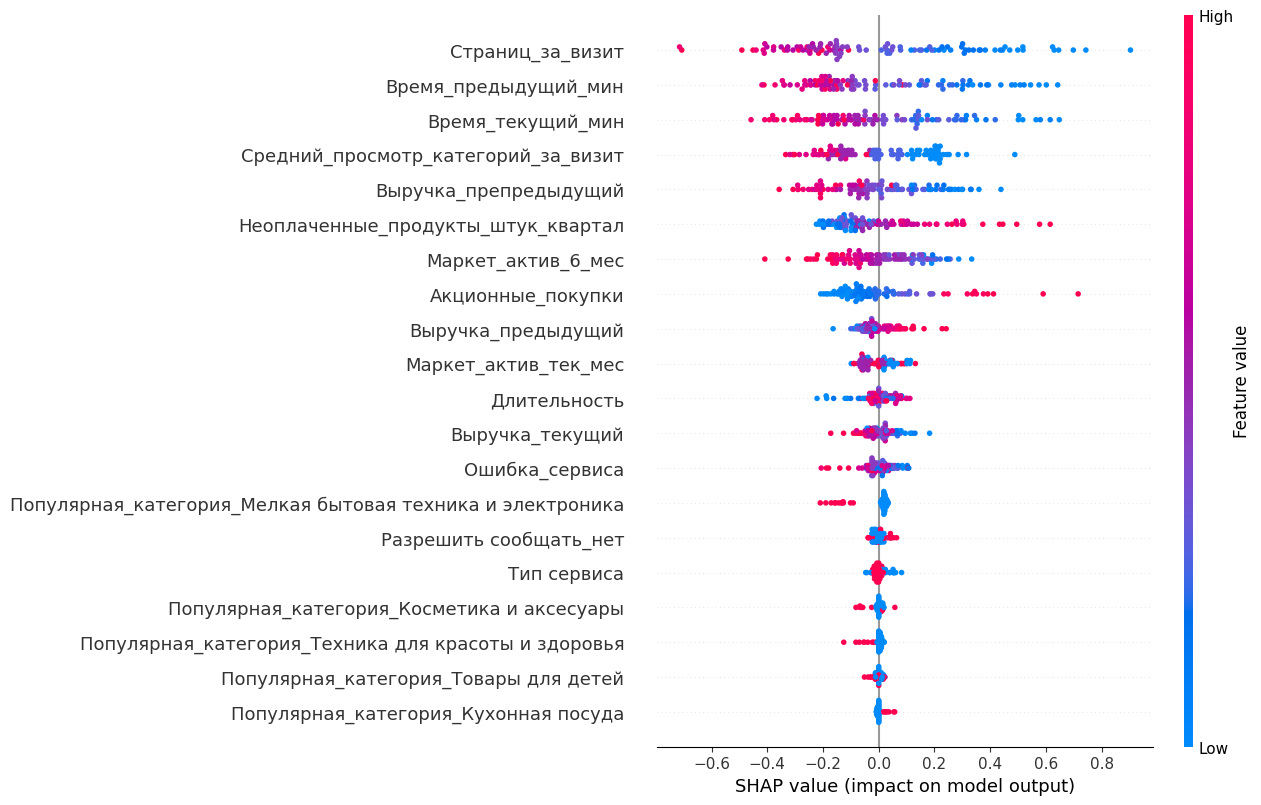

In [122]:
svc_model = best_model.named_steps['models']

explainer = shap.KernelExplainer(svc_model.decision_function, X_sample_transformed, feature_names=columns)
shap_values = explainer(X_sample_transformed)

shap.plots.beeswarm(shap_values, max_display=25) 

### Вывод

Видим, что наиболее значимыми признаками для модели являются:
* количество страниц за визит на сайт
* время, проведенное на сайте
* среднее количество простмотра категорий

Менее всего влияет самая популярная категория и тип сервиса

## Сегментация покупателей

### Подготовка сегментов

Оценка вероятностей на тестовом датасете для предсказания "Снизилась"

In [123]:
money.head(10)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


In [124]:
y_proba = best_model.predict_proba(X)[:, 1]
y_proba = pd.DataFrame(y_proba)
y_proba.columns = ['Вероятность_снижения']
y_proba

,Вероятность_снижения
0,0.979735
1,0.548635
2,0.819050
3,0.949419
4,0.808585
...,...
1291,0.086616
1292,0.034703
1293,0.038189
1294,0.124337


In [125]:
predict_table = pd.merge(y_proba, money, left_index=True, right_index=True)
predict_table = pd.merge(predict_table, market, left_index=True, right_index=True)
predict_table = predict_table.drop(['id_x'], axis=1)
predict_table.rename(columns = {'id_y': 'id'}, inplace = True)
predict_table.head()

,Вероятность_снижения,Прибыль,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий,Выручка_предыдущий,Выручка_препредыдущий,Время_текущий_мин,Время_предыдущий_мин
0,0.979735,0.98,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12
1,0.548635,4.16,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8
2,0.819050,3.13,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13,11
3,0.949419,4.87,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8
4,0.808585,4.21,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10


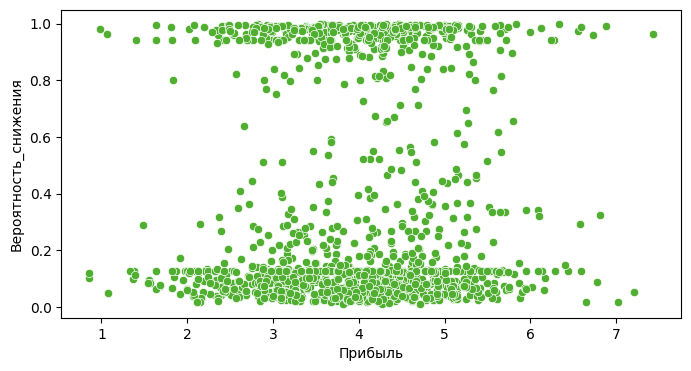

In [128]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x=predict_table['Прибыль'], y=predict_table['Вероятность_снижения'], color='#50af31') 
plt.show()

Определим границы сегмента

In [129]:
probability_reduction = 0.6
segment = predict_table[predict_table['Вероятность_снижения'] > probability_reduction]
profit = segment['Прибыль'].quantile(0.75)
segment = segment[segment['Прибыль'] > profit]
segment.head(10)

,Вероятность_снижения,Прибыль,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий,Выручка_предыдущий,Выручка_препредыдущий,Время_текущий_мин,Время_предыдущий_мин
3,0.949419,4.87,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8
7,0.979189,5.26,215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4566.4,4146.5,4433.0,7,6
11,0.841708,5.08,215362,Снизилась,премиум,да,4.2,4,438,0.74,Домашний текстиль,3,4,6,4,4447.9,4314.0,4765.0,13,13
20,0.942365,6.27,215371,Снизилась,стандарт,да,3.8,4,365,0.21,Домашний текстиль,5,0,6,1,6937.7,6809.0,4742.0,10,10
36,0.957398,4.78,215388,Снизилась,стандарт,да,3.5,4,663,0.99,Домашний текстиль,4,2,2,2,3232.2,3188.0,4182.0,12,10
37,0.981840,4.85,215389,Снизилась,премиум,да,4.1,3,1047,0.93,Товары для детей,5,2,3,7,4429.1,4550.0,4484.0,7,7
40,0.984126,5.16,215392,Снизилась,премиум,да,3.9,3,525,0.28,Кухонная посуда,5,0,4,4,5234.4,4548.0,4341.0,7,7
42,0.979664,5.70,215394,Снизилась,стандарт,да,3.0,5,966,0.30,Товары для детей,3,1,2,4,5651.4,5420.0,4952.0,7,8
43,0.942383,5.44,215395,Снизилась,премиум,да,1.5,5,645,0.27,Товары для детей,3,3,6,5,5677.1,5297.5,4972.0,9,9
48,0.980397,5.09,215400,Снизилась,стандарт,нет,4.4,5,304,0.94,Товары для детей,1,4,3,2,5691.4,5681.0,4439.0,9,11


Отобрали покупателей, от которых высокая прибыль и высокая вероятность снижения покупательской активности

### Увеличение покупательской активности

Выберем группу - люди, которые покупают только технику и попробуем увеличить ее покупательскую активность

In [130]:
predict_table['Популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Кухонная посуда', 'Техника для красоты и здоровья',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [131]:
only_technic = segment[(predict_table['Популярная_категория'] == 'Мелкая бытовая техника и электроника') |
                       (predict_table['Популярная_категория'] == 'Техника для красоты и здоровья')]
only_technic

/var/folders/t5/4y4t4jr53hn5d6844bmbxxvc0000gn/T/ipykernel_68166/4066109183.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  only_technic = segment[(predict_table['Популярная_категория'] == 'Мелкая бытовая техника и электроника') |


,Вероятность_снижения,Прибыль,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий,Выручка_предыдущий,Выручка_препредыдущий,Время_текущий_мин,Время_предыдущий_мин
51,0.969300,5.01,215403,Снизилась,премиум,да,1.7,5,771,0.39,Техника для красоты и здоровья,1,8,2,5,6427.2,5824.0,4957.0,8,7
157,0.975180,6.55,215509,Снизилась,премиум,да,4.0,5,982,0.94,Мелкая бытовая техника и электроника,3,1,2,6,5299.3,5265.5,4880.0,6,8
176,0.974983,4.97,215528,Снизилась,стандарт,да,4.4,4,773,0.98,Мелкая бытовая техника и электроника,3,3,8,6,6103.3,5270.0,4502.0,8,8
220,0.941670,5.49,215572,Снизилась,стандарт,да,3.5,4,676,0.32,Техника для красоты и здоровья,3,7,3,3,4033.7,3879.0,4822.0,15,16
225,0.893264,4.74,215577,Снизилась,стандарт,да,3.9,3,564,0.93,Техника для красоты и здоровья,3,4,2,5,5663.5,4942.0,4774.0,13,12
234,0.972589,5.06,215586,Снизилась,премиум,да,4.1,4,557,0.94,Техника для красоты и здоровья,1,8,3,3,3742.4,4148.0,4349.0,14,11
292,0.918296,5.14,215644,Снизилась,премиум,да,3.5,5,929,0.99,Техника для красоты и здоровья,3,3,4,5,4125.1,3479.0,4772.0,10,13
301,0.942402,5.71,215653,Снизилась,стандарт,нет,5.6,5,181,0.31,Мелкая бытовая техника и электроника,1,5,3,4,5854.2,5121.0,4719.0,13,7
342,0.813916,5.66,215694,Снизилась,премиум,да,5.5,5,982,0.94,Мелкая бытовая техника и электроника,3,1,8,10,5174.4,5118.5,5204.0,19,18
386,0.987190,4.87,215738,Снизилась,премиум,нет,4.6,5,187,0.23,Мелкая бытовая техника и электроника,1,3,3,2,4445.4,4773.0,4500.0,7,9


In [132]:
only_technic.describe()

,Вероятность_снижения,Прибыль,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий,Выручка_предыдущий,Выручка_препредыдущий,Время_текущий_мин,Время_предыдущий_мин
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.00000,15.000000,15.00000,15.000000,15.000000,15.000000
mean,0.853934,5.292667,215796.533333,4.300000,4.466667,671.466667,0.629333,2.333333,3.600000,3.533333,5.80000,5233.753333,4809.00000,4761.466667,10.600000,11.733333
std,0.137149,0.484215,349.682890,0.980525,0.639940,271.087721,0.350438,0.975900,2.472708,2.231805,2.88345,893.920606,792.43801,283.484660,3.680062,3.918211
min,0.614909,4.720000,215403.000000,1.700000,3.000000,181.000000,0.170000,1.000000,0.000000,0.000000,2.00000,3742.400000,3233.00000,4349.000000,6.000000,7.000000
25%,0.750434,4.990000,215574.500000,3.950000,4.000000,550.500000,0.280000,1.500000,2.000000,2.000000,3.50000,4424.200000,4460.50000,4522.500000,8.000000,8.500000
50%,0.918296,5.150000,215653.000000,4.400000,5.000000,723.000000,0.910000,3.000000,3.000000,3.000000,5.00000,5299.300000,4942.00000,4772.000000,10.000000,11.000000
75%,0.970945,5.575000,215928.500000,4.750000,5.000000,868.500000,0.940000,3.000000,4.500000,4.000000,7.50000,5962.900000,5267.75000,4918.500000,13.000000,13.000000
max,0.987190,6.550000,216510.000000,5.600000,5.000000,1022.000000,0.990000,4.000000,8.000000,8.000000,11.00000,6427.200000,5824.00000,5290.000000,19.000000,20.000000


In [133]:
only_technic.head()

,Вероятность_снижения,Прибыль,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий,Выручка_предыдущий,Выручка_препредыдущий,Время_текущий_мин,Время_предыдущий_мин
51,0.969300,5.01,215403,Снизилась,премиум,да,1.7,5,771,0.39,Техника для красоты и здоровья,1,8,2,5,6427.2,5824.0,4957.0,8,7
157,0.975180,6.55,215509,Снизилась,премиум,да,4.0,5,982,0.94,Мелкая бытовая техника и электроника,3,1,2,6,5299.3,5265.5,4880.0,6,8
176,0.974983,4.97,215528,Снизилась,стандарт,да,4.4,4,773,0.98,Мелкая бытовая техника и электроника,3,3,8,6,6103.3,5270.0,4502.0,8,8
220,0.941670,5.49,215572,Снизилась,стандарт,да,3.5,4,676,0.32,Техника для красоты и здоровья,3,7,3,3,4033.7,3879.0,4822.0,15,16
225,0.893264,4.74,215577,Снизилась,стандарт,да,3.9,3,564,0.93,Техника для красоты и здоровья,3,4,2,5,5663.5,4942.0,4774.0,13,12


С помощью функции, которую использовали в статистическом анализе построим гистограммы количественных признаков

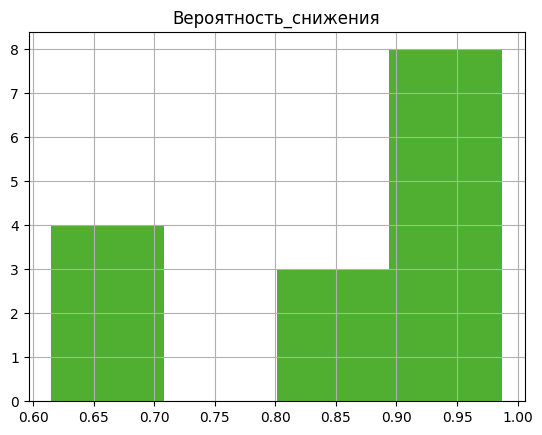

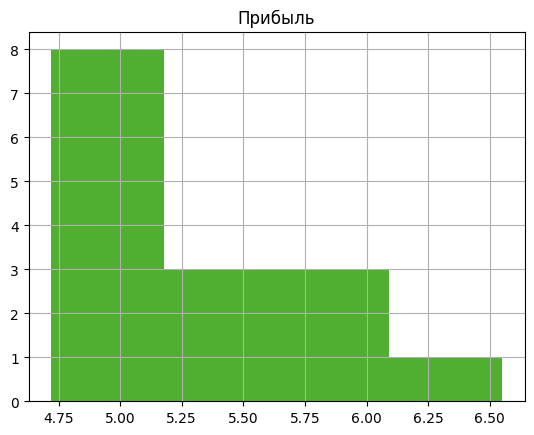

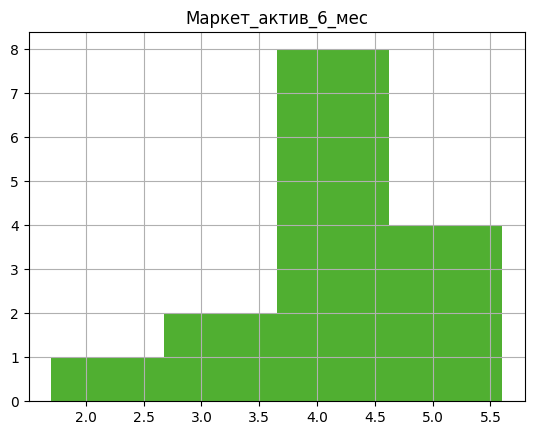

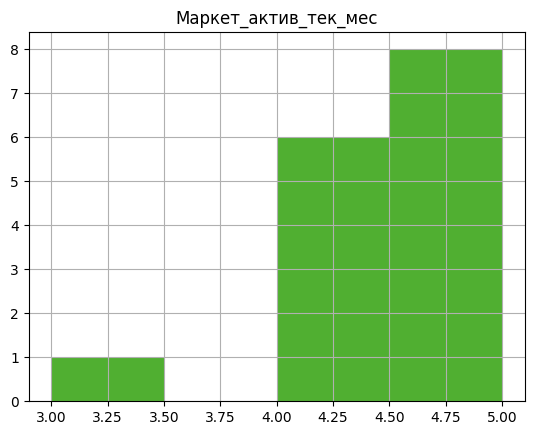

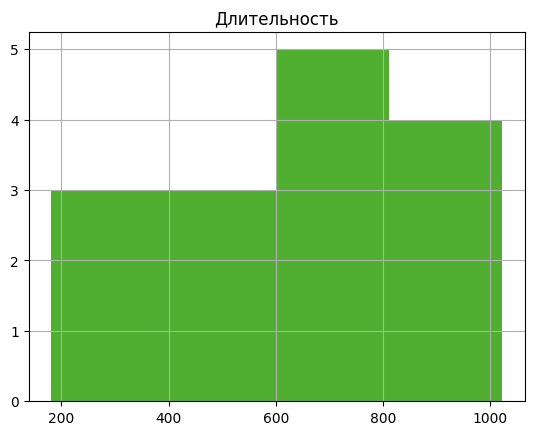

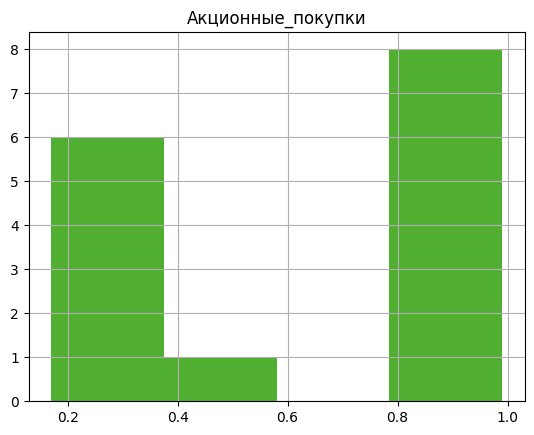

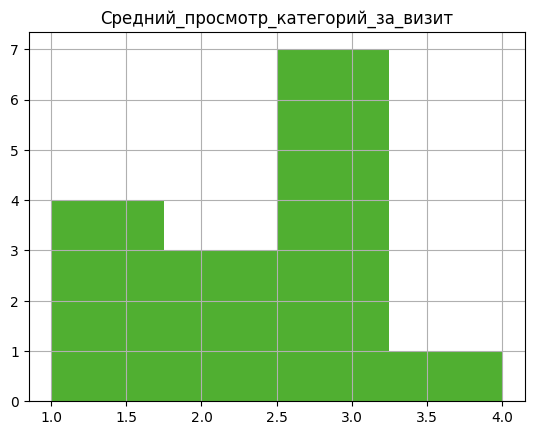

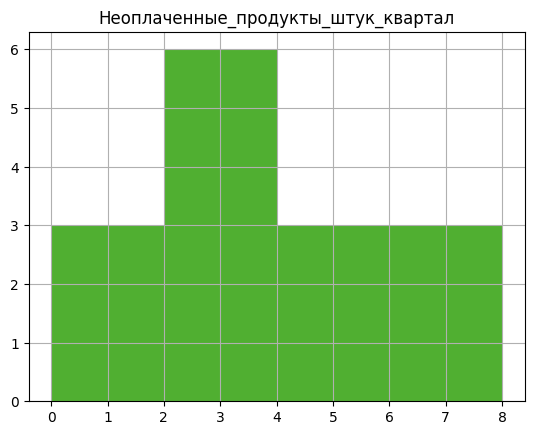

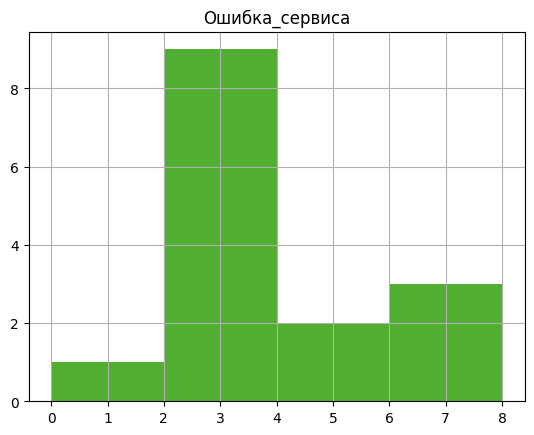

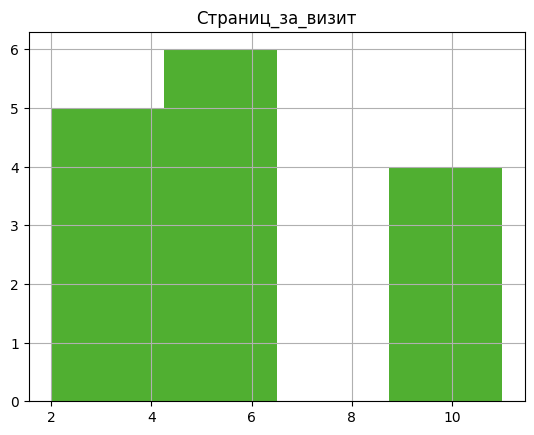

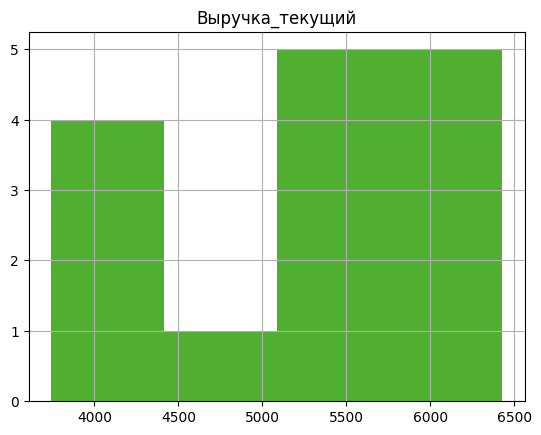

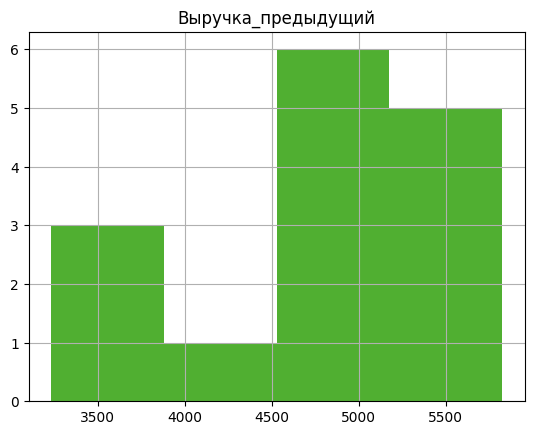

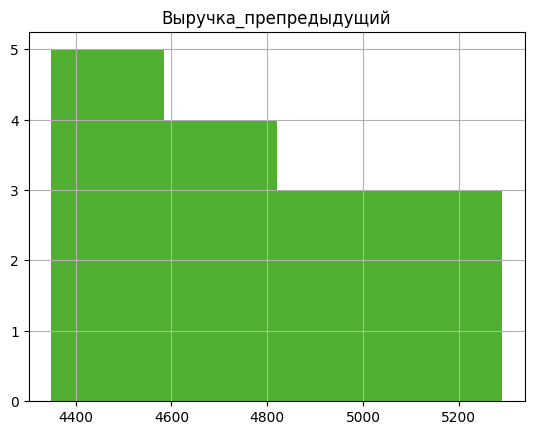

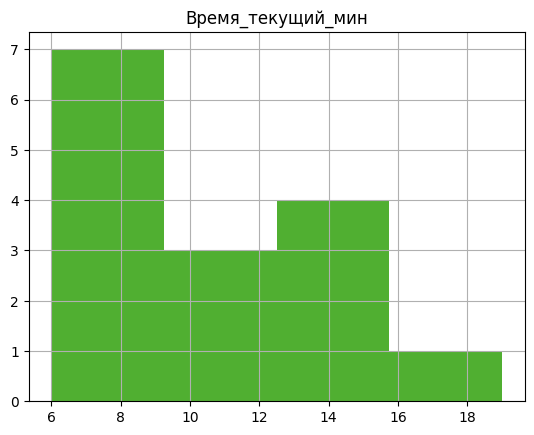

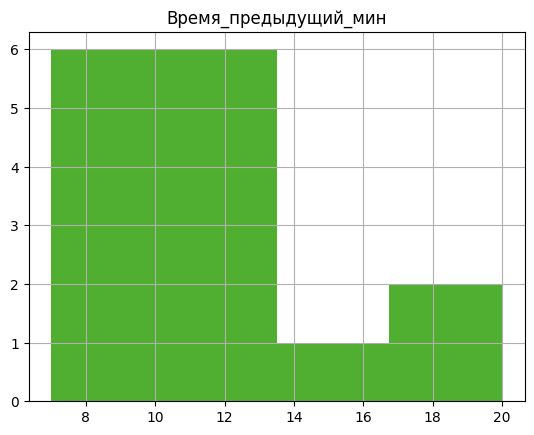

In [134]:
build_hist(only_technic)

Видим, что маркетинговый актив с такими покупателями на том же уровне, как и к другим сегментам. Количество новых покупателей этой группы тоже уменьшилось за последнее время. В отличие от остальных покупателей клиенты этого сегмента гораздо чаще берут товары без скидок. У таких клиентов, как правило, больше неоплаченных покупок за квартал. Страниц за визит на сайт они в среднем открывают в два раза больше. Выручка от этого сегмента в текущем месяце имеет более менее нормальное распределение, в отличие от препредыдущего. Среднее время, проводимое на сайте магазина уменьшилось по сравнению с предыдущим месяцем на 3 мин.

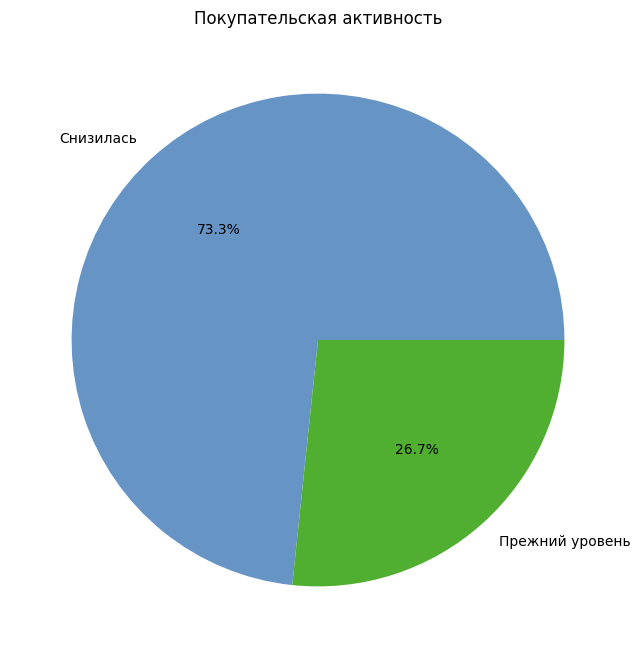

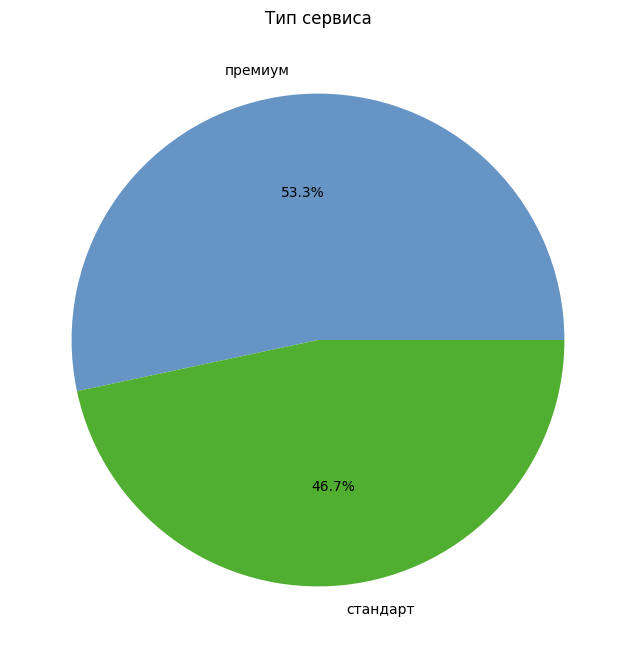

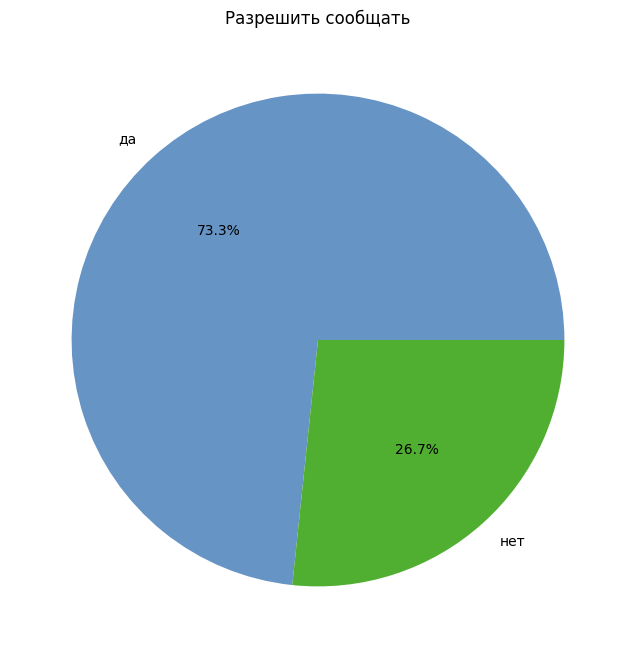

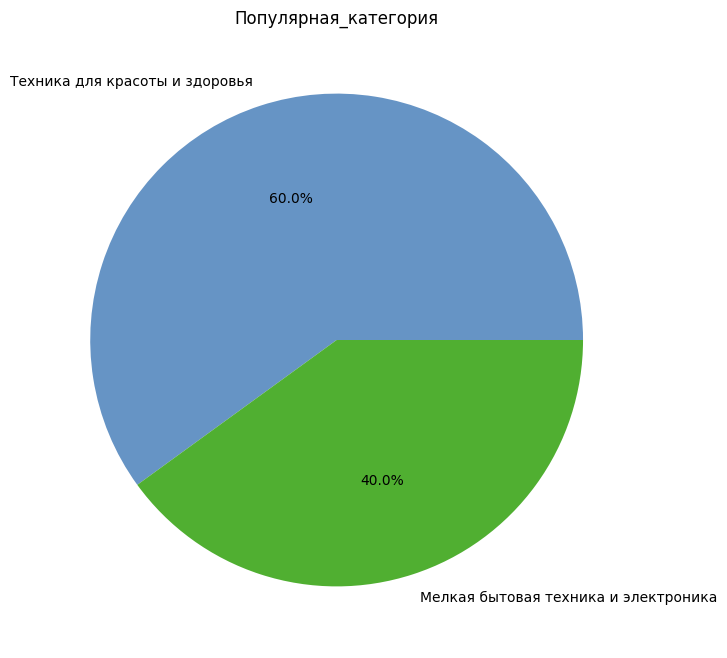

In [135]:
categorical_data(only_technic)

__Предложения по работе с сегментом для увеличения покупательской активности.__

1. Большинство людей из данного сегмента разрешают маркетинговое взаимодействие - можно увеличить его количество конкретно для этой группы покупателей
2. Доля неоплаченных покупок у этого сегмента гораздо больше, чем у остальных покупателей - стоит ввести скидки, которые будут подталкивать клиентов на покупку
3. Так как люди, из этой группы покупателей проводят больше времени на сайте, чем другие, можно улучшить его, добавить более расширенные описания товаров и открытые отзывы
4. Стоит минимизировать возможность сбоя на сайте

### Вывод

В данном пункте выделили несколько сегментов покупателей, выбрали тот, в котором люди покупают только технику и сделали предложения по увеличению покупательской активности этих клиентов

## Общий вывод

* В данном проекте проанализировали данные о постоянных покупателях Интернет-магазина «В один клик»;
* Сделали необходимую предобработку - удалили неявные дубликаты и поменяли типы данных;
* Нашли взаимосвязи в данных - удалили выручку за предыдущий месяц
* Построили модель предсказания вероятности снижения покупательской активности клиента в следующие три месяца. Нашли лучшую для этого модель, ей оказалась SVC(C=1). Для этого использовали пайплайн, в котором попробовали четыре различных модели с различными гиперпараметрами. Метрика модели на тестовой выборке - 0.91;
* Разделили покупателей на сегменты;
* Поработав с сегментов покупателей только техники сделали предложения по увеличению покупательской их активности. 